In [1]:
#These lines set up inline plotting, and apply a standard size
%matplotlib inline
import matplotlib
matplotlib.rc('font', **{'size': 22})
# Standard includes
from datetime import datetime
import re
import os
import json
from elasticsearch import Elasticsearch
from elasticsearch.helpers import scan
import matplotlib.pyplot as plt
from time import time
import timeit
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from matplotlib.dates import DateFormatter
from matplotlib.dates import HourLocator
from numpy import genfromtxt

In [ ]:
# Define query for the tasks
#taskQuery = {
#   "query": {
#        "bool": {
#            "should": [
#                {"term":{"transhome": "AthDerivation-21.2.38.0"}}
#            ]
#        }
#    }
#}
taskQuery = {
    "query": {
        "wildcard": {
            "taskname": "*.deriv.*"
        }
    }
}

In [ ]:
# Execute the queries
es = Elasticsearch(['atlas-kibana-dev.mwt2.org'],timeout=120)

# Tasks
taskIndex = "tasks*"
tasks = scan(es, query=taskQuery, index=taskIndex, scroll='5m', timeout="5m", size=1000)

In [2]:
my_data = pd.read_csv('jobnumbers.csv', header = 0, index_col='S_DATE') 
my_nev  = pd.read_csv('nevents_all.csv', header = 0, index_col='creationtime per day') 
                      #dtype = {'SUM': float,'S_DATE': str,'S_SITE': str})
#my_data = genfromtxt('jobnumbers.csv', delimiter=',',skip_header=1,
#                    dtype=[np.dtype(float),np.dtype(str),np.dtype(str)])

In [3]:
do = datetime.now() + timedelta(1)#datetime.strptime('2018-08-14T18:36:13.0', '%Y-%m-%dT%H:%M:%S.0')
ps = datetime.now() + timedelta(-31)
print(do.day)
print(do.month)
print(do.year)
print(ps.day)
print(ps.month)
print(ps.year)
date = np.arange(np.datetime64('%s-%02d-%02d'%(ps.year,int(ps.month),int(ps.day))),
                np.datetime64('%s-%02d-%02d'%(do.year,int(do.month),int(do.day))))              

6
9
2018
5
8
2018


In [4]:
run_nevents = {}
nidx = 0
for i in my_nev.index:
    do = datetime.fromtimestamp(i/1000.)
    do += timedelta(days=1)
    if not do in run_nevents.keys(): run_nevents[do] = 0
    #print(nidx)
    run_nevents[do] += my_nev['Sum of nevents'][i]
    nidx += 1
names = ['date','nevt']
formats = ['datetime64[D]','f8']
dtype = dict(names = names, formats=formats)
run_nevents_array = np.array(sorted(list(run_nevents.items())), dtype=dtype)
run_nevents_array_dates = np.empty(date.shape,dtype=dtype)
i = 0
for rna in run_nevents_array:   
    if rna[0] in date:
        run_nevents_array_dates[i] = rna
        i += 1
#run_nevents_array = np.where(run_nevents_array==date)
print(run_nevents_array_dates)

[('2018-08-05', 4.46007430e+09) ('2018-08-06', 3.72442808e+09)
 ('2018-08-07', 5.17708780e+09) ('2018-08-08', 4.49812972e+09)
 ('2018-08-09', 7.69808999e+09) ('2018-08-10', 5.15315089e+09)
 ('2018-08-11', 5.16023412e+09) ('2018-08-12', 4.02814968e+09)
 ('2018-08-13', 5.21954744e+09) ('2018-08-14', 5.95220775e+09)
 ('2018-08-15', 2.43559019e+09) ('2018-08-16', 2.07946076e+09)
 ('2018-08-17', 2.89938986e+09) ('2018-08-18', 1.79707802e+09)
 ('2018-08-19', 2.62273607e+09) ('2018-08-20', 2.90974873e+09)
 ('2018-08-21', 2.75271766e+09) ('2018-08-22', 3.00266018e+09)
 ('2018-08-23', 2.58787122e+09) ('2018-08-24', 3.26530975e+09)
 ('2018-08-25', 4.75359084e+09) ('2018-08-26', 2.91090026e+09)
 ('2018-08-27', 2.84820968e+09) ('2018-08-28', 3.29140711e+09)
 ('2018-08-29', 3.21292642e+09) ('2018-08-30', 2.16943224e+09)
 ('2018-08-31', 2.10279680e+09) ('2018-09-01', 2.48930442e+09)
 ('2018-09-02', 2.55700506e+09) ('2018-09-03', 2.19314379e+09)
 ('2018-09-04', 1.43960034e+09) ('2018-09-05', 7.241505

In [ ]:
print(rna[0])

In [6]:
run_slots = {}
nidx = 0
for i in my_data.index:
    do = datetime.strptime(i, '%d-%b-%y %H:%M:%S')
    if not do in run_slots.keys(): run_slots[do] = 0
    run_slots[do] += my_data['SUM'][nidx]
    nidx += 1
names = ['date','slots']
formats = ['datetime64[D]','f8']
dtype = dict(names = names, formats=formats)
run_slots_array = np.array(sorted(list(run_slots.items())), dtype=dtype)
run_slots_array_dates = np.empty(date.shape,dtype=dtype)
i = 0
for rsa in run_slots_array:   
    if rsa[0] in date:
        run_slots_array_dates[i] = rsa
        i += 1
#run_nevents_array = np.where(run_nevents_array==date)
print(run_slots_array_dates)

[('2018-08-05', 59006.) ('2018-08-06', 51383.) ('2018-08-07', 45617.)
 ('2018-08-08', 42046.) ('2018-08-09', 44780.) ('2018-08-10', 53404.)
 ('2018-08-11', 51381.) ('2018-08-12', 49348.) ('2018-08-13', 45534.)
 ('2018-08-14', 60385.) ('2018-08-15', 41337.) ('2018-08-16', 29033.)
 ('2018-08-17', 30816.) ('2018-08-18', 30753.) ('2018-08-19', 32089.)
 ('2018-08-20', 32609.) ('2018-08-21', 33396.) ('2018-08-22', 31599.)
 ('2018-08-23', 31891.) ('2018-08-24', 33683.) ('2018-08-25', 37849.)
 ('2018-08-26', 37607.) ('2018-08-27', 45035.) ('2018-08-28', 28913.)
 ('2018-08-29', 29114.) ('2018-08-30', 27759.) ('2018-08-31', 31201.)
 ('2018-09-01', 31727.) ('2018-09-02', 31425.) ('2018-09-03', 29899.)
 ('2018-09-04', 29300.) ('2018-09-05', 10648.)]


In [ ]:
# Define the trains and the quantities for collection
quantities = [
    'nevents',
    'starttime',
    'endtime',
    'creationtime',
    'jobstatus'
]
# Get the IDs matching each train
start_time = timeit.default_timer()
matchingTasks = 0
item = []
for res in tasks:
    if datetime.fromtimestamp(res['_source']['creationdate']/1000.) < ((datetime.now() + timedelta(1))-timedelta(days=31)):
        continue
    item.append(res['_id'])
    matchingTasks += 1
print("Total matching tasks = ",matchingTasks)
print("Time to extract information = ",timeit.default_timer() - start_time)

In [ ]:
np.arange(np.datetime64('%s-%02d-%02d'%(ps.year,int(ps.month),int(ps.day))),np.datetime64('%s-%02d-%02d'%(do.year,int(do.month),int(do.day))))

In [ ]:
# Set up query for the jobs relevant to the trains
start_time = timeit.default_timer()
taskCounter = 0
jobIndex = "jobs_archive_2018*"
to_read = quantities
nev  = np.zeros(date.shape[0], dtype=np.int64)
for theId in item: # Loop over tasks for that train
    taskCounter += 1
    #taskCounterPerTrain += 1
    #if taskCounterPerTrain > 10: break
    if taskCounter % 100 == 0: 
        et = timeit.default_timer() - start_time
        print("Processing task ",taskCounter," Elapsed Time:", et, '\t projected finish in:',et/taskCounter*matchingTasks - et )
    jobQuery = {
        "_source": to_read,
        "query": {
            "bool": {
                "must": [
                    {"term":{"jeditaskid": theId}},
                    {"term":{"jobstatus": "finished"}}
                ]
            }
        }
    }
    # query the jobs
    jobs = scan(es, query=jobQuery, index=jobIndex, scroll='5m', timeout="5m", size=1000)
    for res in jobs: # Loop over jobs from that task
        st = datetime.strptime(res['_source']['starttime'], '%Y-%m-%dT%H:%M:%S.0')
        en = datetime.strptime(res['_source']['endtime'], '%Y-%m-%dT%H:%M:%S.0')
        if st.day != en.day:
            en += timedelta(days=1)
            day_range = np.arange(np.datetime64('%s-%02d-%02d'%(st.year,int(st.month),int(st.day))),
                                  np.datetime64('%s-%02d-%02d'%(en.year,int(en.month),int(en.day))))
            if day_range.shape[0] > 2:
                print(day_range,float(day_range.shape[0]))
            for dtstr in day_range:
                itemindex = np.where(date==dtstr) 
                if itemindex[0].shape[0] == 0:
                    print("Not valid for date %s-%02d-%02d"%(st.year,int(st.month),int(st.day)+1))
                continue
                try:
                    nev[itemindex[0][0]] += res['_source']['nevents']/float(day_range.shape[0])
                except:
                    print("Index %i is not valid for date %s-%02d-%02d"%(itemindex,do.year,int(do.month),int(do.day)+1))
            continue
        
        dtstr = np.datetime64('%s-%02d-%02d'%(st.year,int(st.month),int(st.day)))
        itemindex = np.where(date==dtstr) 
        if itemindex[0].shape[0] == 0:
            print("Not valid for date %s-%02d-%02d"%(st.year,int(st.month),int(st.day)))
            continue
        try:
            nev[itemindex[0][0]] += res['_source']['nevents']
        except:
            print("Index %i is not valid for date %s-%02d-%02d"%(itemindex,st.year,int(st.month),int(st.day)))


In [7]:
x_slots = []
y_slots = []
x_nev = []
y_nev = []
for i in range(run_slots_array_dates.shape[0]):
    x_slots.append(run_slots_array_dates[:][i][0])
    y_slots.append(run_slots_array_dates[:][i][1])
for i in range(run_nevents_array_dates.shape[0]):
    x_nev.append(run_nevents_array_dates[:][i][0])
    y_nev.append(run_nevents_array_dates[:][i][1])

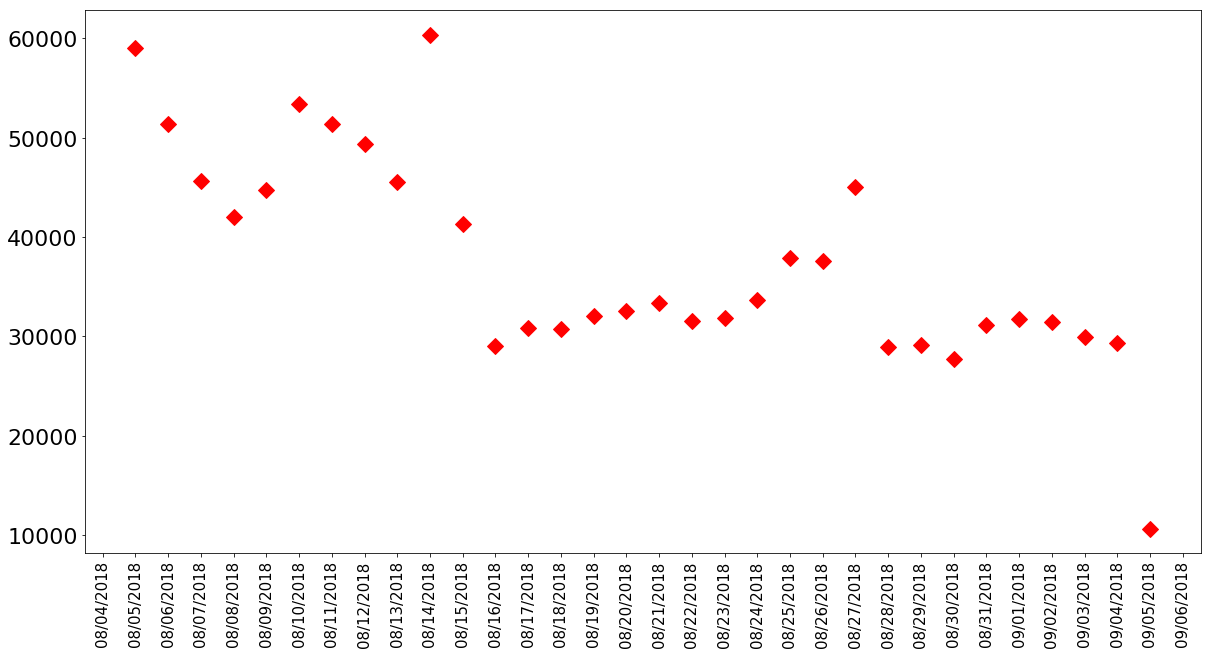

In [8]:
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(20,10))
plt.xticks(np.arange(min(x_slots), max(x_slots),dtype=np.datetime64),rotation='vertical')
ax.tick_params(axis='x', labelsize=15)
lst = plt.plot_date(x_slots,y_slots,marker='D',ms=12,color='r')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())

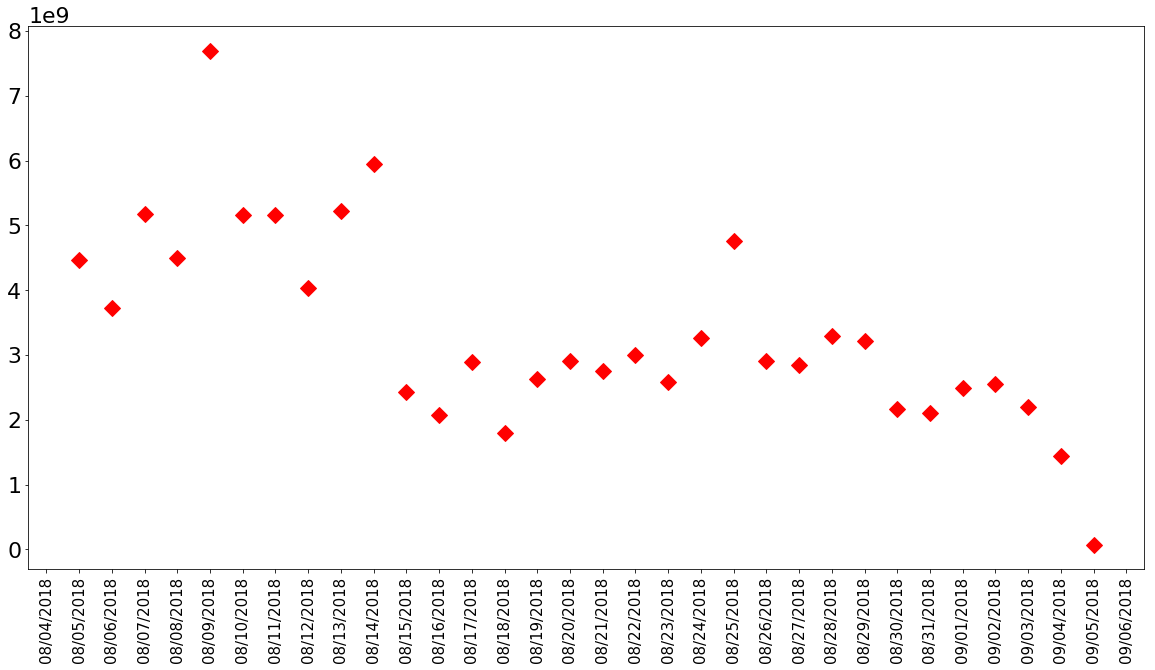

In [9]:
fig, ax = plt.subplots(figsize=(20,10))
plt.xticks(np.arange(min(x_nev), max(x_nev),dtype=np.datetime64),rotation='vertical')
ax.tick_params(axis='x', labelsize=15)
lst = plt.plot_date(x_nev,y_nev,marker='D',ms=12,color='r')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())

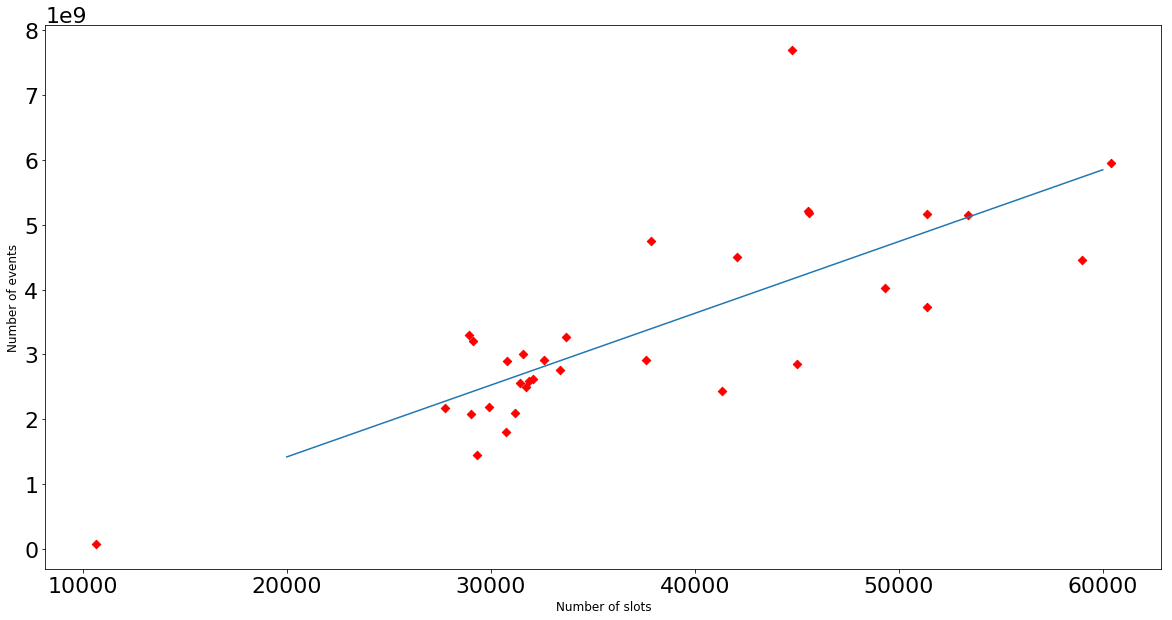

[-7.97366665e+08  1.10764437e+05]


In [13]:
# Generated linear fit
import numpy.polynomial.polynomial as poly
fig, ax = plt.subplots(figsize=(20,10))
ax.scatter(y_slots,y_nev,marker="D",color='r')
ax.set_xlabel('Number of slots',fontsize=12)
ax.set_ylabel('Number of events',fontsize=12)
x_new = np.linspace(20000, 60000, num=len(y_slots)*10)
coefs = poly.polyfit(y_slots,y_nev,deg=1)
ffit = poly.polyval(x_new, coefs)
plt.plot(x_new, ffit)
plt.show()
print(coefs)

In [ ]:
sorted(x)

In [ ]:
date